# 2 ML Features Selection & Model Training




In [1]:
# # Save Current Session
# import dill

# dill.dump_session('temp_save_session.pkl')

In [2]:
# # Load a previous session
# import dill

# dill.load_session('temp_save_session.pkl')

# Imports & Functions

## Imports

In [3]:
# General imports
import os
import sys
import gc
import warnings
from typing import Literal

from datetime import datetime
from pprint import pprint
import time
import pickle
import cloudpickle
import random
from collections import Counter

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# ML Prep
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import make_column_selector

# ML Training
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
# from ml_utilities import ml_model_pipeline_details, grid_search_results
# from ml_utilities import ml_model_pipeline_details, grid_search_results, classification_metrics 
# from ml_utilities import feature_importance, get_shap_importance, get_prediction_probabilities
import shap

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier



## Functions - Results & Features Inspection

In [4]:
# Plots for subject info
#

def subject_info_plot(subjects_df):

    # PD & Gender
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle('Study Subjects - PD & Gender', fontsize=18)

    counts = subjects_df['pd'].value_counts()
    axes[0].set_title('PD')
    axes[0].bar(counts.index.astype(str), counts.values, color=['skyblue', 'skyblue'], edgecolor='black')
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    counts = subjects_df['gender'].value_counts()
    axes[1].set_title('Gender')
    axes[1].bar(counts.index.astype(str), counts.values, color=['skyblue', 'skyblue'], edgecolor='black')
    axes[1].set_xticks(range(len(counts.index)))
    axes[1].set_xticklabels(['Male', 'Female'])
    for i, (label, count) in enumerate(counts.items()):
        axes[1].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Age Distribution & Box
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle('Study Subjects - Age Distribution', fontsize=18)

    axes[0].hist(subjects_df['age'], bins=15, color='skyblue', edgecolor='black')

    axes[1].set_xticks([0])
    box = axes[1].boxplot(subjects_df['age'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


In [5]:
# Plots for EEG Preprocessing Results
#

def eeg_preprocess_results_plot(results_df):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle('EEG Preprocessing Metrics - All Subjects', fontsize=18)

    # Quality Warning
    counts = results_df['EEG_preprocessing_quality_warning'].value_counts().reindex([True, False], fill_value=0)
    axes[0].set_title('Overall Quality Warning Count')
    axes[0].bar(counts.index.astype(str), counts.values, color=['salmon', 'lightgreen'], edgecolor='black')
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    # # Channels count
    # counts = results_df['channel_count'].value_counts()
    # axes[1].set_title('Channels Count')
    # axes[1].bar(counts.index.astype(str), counts.values, color=['skyblue'], edgecolor='black')

    # ICA Rejection Level
    axes[1].set_title('ICA - ICs Rejection Level')
    box = axes[1].boxplot(results_df['ICA_rejection_level'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # Epoch Rejection Level
    axes[2].set_title('Epoch Rejection Level')
    box = axes[2].boxplot(results_df['epoch_rejection_level'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')
    # axes[2].set_xlabel('Epoch Rejection Level')
    # axes[2].set_ylabel('Number of Subjects')
    # axes[2].hist(results_df['epoch_rejection_level'], bins=10, color='skyblue', edgecolor='black')
    # nonzero_epoch_rejection = results_df['epoch_rejection_level'][results_df['epoch_rejection_level'] > 0]
    # axes[2].hist(nonzero_epoch_rejection, bins=15, color='salmon', edgecolor='black', alpha=0.7)
    # for bar in axes[2].patches:
    #     bar.set_width(bar.get_width() * 0.8)

    plt.tight_layout()
    plt.show()


In [6]:
# Plots for EEG SpecParam Results
#

def eeg_specparam_results_plot(results_df):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle('EEG SpecParam Fit Metrics - All Subjects', fontsize=18)

    # Quality Warning
    counts = results_df['chn_SPM_fit_quality_warning'].value_counts().reindex([True, False], fill_value=0)
    axes[0].set_title('Overall Quality Warning Count')
    axes[0].bar(counts.index.astype(str), counts.values, color=['salmon', 'lightgreen'], edgecolor='black')
    
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    # Error Mean
    axes[1].set_title('Error Mean')
    box = axes[1].boxplot(results_df['chn_error_mean'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # R-Squared Mean
    axes[2].set_title('R2 Mean')
    box = axes[2].boxplot(results_df['chn_r2_mean'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()

    # Number of flagged channels
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 4))
    # fig.suptitle('EEG SpecParam Fit Metrics - Flagged Channels', fontsize=18)
    flagged_counts = results_df['chn_flagged_channels'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    axes.set_title('Flagged Channels Count')
    box = axes.boxplot(flagged_counts, patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='salmon')

    plt.tight_layout()
    plt.show()

In [7]:
# Plots for Aperiodic Features Spread
#

def aperiodic_features_plot(results_df, level):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle(f'Aperiodic Features - {level}', fontsize=18)

    # Offset
    axes[0].set_title('Offset')
    box = axes[0].boxplot(results_df['offset'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # Exponent
    axes[1].set_title('Exponent')
    box = axes[1].boxplot(results_df['exponent'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


In [8]:
# Plots for Periodic Features Spread
#

def periodic_features_plot(results_df, level):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle(f'Periodic Features - {level}', fontsize=18)

    # CF
    axes[0].set_title('CF_0')
    box = axes[0].boxplot(results_df['cf_0'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # PW
    axes[1].set_title('PW_0')
    box = axes[1].boxplot(results_df['pw_0'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # BW
    axes[2].set_title('BW_0')
    box = axes[2].boxplot(results_df['bw_0'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


In [9]:
# Plots for Aperiodic Peaks Count 
#

def periodic_peaks_plot(results_df):

    regions_df = results_df[results_df['channel'].isnull()].copy()
    cf_cols = [col for col in regions_df.columns if col.startswith('cf_')]
    regions_df['num_periodic_cf'] = regions_df[cf_cols].notnull().sum(axis=1)
    
    channels_df = results_df[results_df['region'].isnull()].copy()
    cf_cols = [col for col in channels_df.columns if col.startswith('cf_')]
    channels_df['num_periodic_cf'] = channels_df[cf_cols].notnull().sum(axis=1)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle(f'Periodic Peaks Count', fontsize=18)

    # Region
    axes[0].set_title('Regions')
    box = axes[0].boxplot(regions_df['num_periodic_cf'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # Channel
    axes[1].set_title('Channels')
    box = axes[1].boxplot(channels_df['num_periodic_cf'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


## Functions - Training

In [10]:
# Feature Selection using a Custom Transformer class
#

class FeatureSelection(BaseEstimator, TransformerMixin):

    def __init__(self, features_detail_level='default', selected_features='default'):
        # Parameters for the selection
        self.features_detail_level = features_detail_level
        self.selected_features = selected_features

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_temp_df = X.copy()
        else:
            raise ValueError("X must be a pandas DataFrame for feature selection.")
        
        # Filter out features according to detail level, ie region or channel
        drop_cols =[]
        if self.features_detail_level == 'region':
            drop_cols = drop_cols + [col for col in X_temp_df.columns if col.startswith('channel')]
        elif self.features_detail_level == 'channel':
            drop_cols = drop_cols +[col for col in X_temp_df.columns if col.startswith('region')]
        else:
            raise ValueError(f'Detail of {self.features_detail_level} is not region or channel')
        X_temp_df = X_temp_df.drop(columns=drop_cols, errors='ignore')
        
        # Only retain columns whose names contain any of the selected features
        X_temp_df = X_temp_df[[col for col in X_temp_df.columns if any(feat in col for feat in self.selected_features)]]
       
        self.selected_features_ = list(X_temp_df)
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_temp_df = X.copy()
        else:
            raise ValueError("X must be a pandas DataFrame for feature selection.")
        
        # Apply feature selection
        return X[self.selected_features_]


In [11]:
# Data Prep Pipeline
#

def data_prep_pipeline():

    # Sub pipeline for numerical and categorical transformations
    num_pipeline = Pipeline([
        ('impute', SimpleImputer(keep_empty_features=True, strategy='constant', fill_value=0)),
        # ('scale_num', RobustScaler())
        ('scale_num', RobustScaler(quantile_range=(10.0, 90.0)))
        ])
    cat_pipeline = Pipeline([
        # ("impute", SimpleImputer(strategy="most_frequent")),
        # ("encode_cat", OneHotEncoder(handle_unknown="ignore", sparse=False))
        ('encode_cat', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'))
        ])
    cols_transform = ColumnTransformer([
        ('numeric', num_pipeline, make_column_selector(dtype_include=['float64', 'int64'])),
        ('categorical', cat_pipeline, make_column_selector(dtype_include='object'))
    ])

    # Setup & train/fit the overall pipeline
    features_prep_pipeline = Pipeline([
        ('data_preprocess', cols_transform)
        ])  
    
    return features_prep_pipeline

In [12]:
# Model Evaluation
#

def evaluate_model(model, X_test, y_test, verbose=True):

    # Run predictions
    start_time = time.perf_counter()
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)
    duration = time.perf_counter() - start_time

    # Calculate Metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    recall = metrics.recall_score(y_true=y_test, y_pred=y_pred, pos_label=1)
    precision = metrics.precision_score(y_true=y_test, y_pred=y_pred, pos_label=1)
    f1_score = metrics.f1_score(y_true=y_test, y_pred=y_pred, pos_label=1)
    specificity = tn / (tn + fp)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Print Metrics
    if verbose:
        print(f'----Evaluation Result for: {model.model_name} -------')
        print(f'Recall (Sensitivity, TP Rate): {recall:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'F1 Score {f1_score:.4f}')
        print(f'Specificity (1 - Fall-Out): {specificity:.4f}')
        print(f'MCC: {mcc:.4f}')
        print('-----------')
        print(f'Accuracy: {metrics.accuracy_score(y_true=y_test, y_pred=y_pred):.4f}')
        print(f'Fall Out (FPR): {fp / (fp + tn):.4f}')
        print(f'Hamming Loss {metrics.hamming_loss(y_true=y_test, y_pred=y_pred):.4f}')
        roc_auc_score = metrics.roc_auc_score(y_true=y_test, y_score=y_probs[:,1])
        print(f'ROC-AUC Score {roc_auc_score:.4f}')
        gini_score = 2 * roc_auc_score - 1
        print(f'Gini Index: {gini_score:.4f}')
        print('-----------')

    # Plot Confusion Matrix & ROC Curve
    if verbose:
        plt.style.use('default')
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
        fig.suptitle(f'Model Prediction Evaluation', fontsize=20)

        axes[0].set_title('Confusion Matrix')    
        class_labels = model.classes_
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=axes[0])
        axes[1].set_title('ROC Curve')
        # roc_display = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[1], pos_label=1)
        RocCurveDisplay.from_predictions(y_test, y_probs[:,1], ax=axes[1], pos_label=1)

        plt.tight_layout()
        plt.show()
        plt.style.use('ggplot')

    # Create Predications df With Confidences
    predicted_confidence = [y_probs[i, pred] for i, pred in enumerate(y_pred)]
    predictions_df = pd.DataFrame({
        'Ground_Truth': y_test,
        'Prediction': y_pred,
        'Confidence': predicted_confidence
        })
    # Highlight Mismatches
    if verbose:
        print('Mismatches')
        mismatches = predictions_df[predictions_df['Prediction'] != predictions_df['Ground_Truth']]
        display(mismatches)

    # Return Results
    results = {'study': 'test_study',
               'training_source_data_run': 'test run name',
               'training_results_run': 'test run name',
               'CV_search_time': 0,
               'CV_best_parameters': '{xx}',
               'features_detail': 'test region',
               'features_selection': 'test list',
               'model_name': model.model_name,
               'prediction_time': duration,
               'recall': recall,
               'precision': precision,
               'f1_score': f1_score,
               'specificity': specificity,
               'mcc': mcc
               }
    
    return results, predictions_df

In [13]:
# Calculate Importance / Contribution - SHAP
#

def contribution_shap(model, X_train, X_test):
    model_classifier = model.steps[-1][1] 
    preprocessing_steps = list(model.named_steps.items())[:-1] 
    preprocessing_pipeline = Pipeline(preprocessing_steps)

    X_train_transformed = preprocessing_pipeline.transform(X_train)
    X_test_transformed = preprocessing_pipeline.transform(X_test)
    feature_names = preprocessing_pipeline.named_steps['data_preprocess'].get_feature_names_out()
    print(f'Feature Names: {len(feature_names)}')
    # print(feature_names)

    # Create Explainer with background data 
    def model_predict(X):
        return model_classifier.predict_proba(X)[:, 1] 

    # Calc SHAP values
    background = X_train_transformed[np.random.choice(X_train_transformed.shape[0], 100, replace=False)]
    explainer = shap.KernelExplainer(model_predict, background)
    shap_values = explainer.shap_values(X_test_transformed)

    # Get mean absolute SHAP values for global importance & % additional contribution
    global_importance = np.abs(shap_values).mean(axis=0)
    importance_percentages = (global_importance / global_importance.sum()) * 100
    shap_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance_%': importance_percentages
    }).sort_values(by='importance_%', ascending=False).reset_index(drop=True)

    # Plot the Top 25
    print('SHAP Values Importance')
    print(shap_importance_df.shape)
    display(shap_importance_df.head())

    importance_df = shap_importance_df.head(25)
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['feature'], importance_df['importance_%'], color='skyblue')
    plt.xlabel('Importance %')
    plt.ylabel('Feature')
    plt.title('Feature Importances (Sorted)')
    plt.gca().invert_yaxis() 
    plt.show()

## Functions - Models

In [ ]:
# Grid Search For A Model
#

def run_grid_search(model_pipeline, grid_params, X_train, y_train, verbose=False):

    # # Straight k-fold cross-validation
    # grid_search = GridSearchCV(
    #     model_pipeline, grid_params, cv=5, n_jobs=-1,
    #     scoring='precision'
    #     )

    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        model_pipeline, grid_params, cv=skf, n_jobs=-1,
        # scoring='precision'
        # scoring='f1'
        # scoring='roc_auc'
        scoring='matthews_corrcoef'
        )

    # Grid search run
    start_time = time.perf_counter()
    grid_search.fit(X_train, y_train)
    duration = time.perf_counter() - start_time

    # Model Details
    if verbose:
        print('Model Training Pipeline Steps')
        for name, step in model_pipeline.named_steps.items():
            print(f"- {name}: {step}")
        print('All Pipeline Parameters:')
        for param, value in model_pipeline.get_params().items():
            print(f"- {param}: {value}")

    # Grid Search Results
    if verbose:
        print('\nGrid Search Results')
        all_search_results = pd.DataFrame(grid_search.cv_results_)
        print(f"Score: {grid_search.best_score_:.4f}. Mean: {np.mean(all_search_results['mean_test_score']):.4f} and STD {np.std(all_search_results['mean_test_score']):.4f}")
        print(f'Search Took: {duration:.2f} seconds')
        print('-----------------')
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f'Best C-V Score: {grid_search.best_score_}')
        top_n = 10
        print(f'Combinations Searched: {len(all_search_results)}')
        print(f"Top {top_n} out of {len(all_search_results)} combinations:")
        display(all_search_results[['rank_test_score', 'mean_test_score', 'mean_fit_time', 'params', 'param_features_selection__features_detail_level', 'param_features_selection__selected_features']].sort_values(by='rank_test_score').head(top_n))
        print('-----------------')
        print(f'Best Model: \n{grid_search.best_estimator_}')

    return duration, grid_search
    

In [ ]:
# Random Forest Model Training Function
#

def model_train_RandForest(X_train, y_train, feature_selector=None, cols_transform=None, detail_level=None, features_selected=None,verbose=False):

    model_name = 'RandomForest_v1'

    # Use the data pipeline in the search
    if feature_selector:
        model_pipeline = Pipeline([
            ('features_selection', feature_selector),
            ('data_preprocess', cols_transform),
            ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, verbose=False))
            ])

        grid_params = {
            'features_selection__features_detail_level': detail_level,
            'features_selection__selected_features': features_selected,
            'classifier__criterion': ['gini', 'entropy', 'log_loss'],     # Default gini. Tree split evaluation function
            'classifier__n_estimators': [100, 150],                       # Default 100. Number of trees
            'classifier__max_depth': [3, 10, 15],                         # Default none, unlimited ... but don't want to overfit
            # 'classifier__max_features': [0.8, 2],                       # Default is sqrt
            'classifier__max_leaf_nodes': [50, None],                     # Default none, unlimited
            # 'randomforestclassifier__min_samples_split': [2, 5],
            # 'classifier__class_weight': [None, 'balanced']              # Balanced gives more importance to minority classes ... ?? Improves recall at the expense of precision
            }
    else:
        model_pipeline = Pipeline([
            ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, verbose=False))
            ])

        grid_params = {
            'classifier__criterion': ['gini', 'entropy', 'log_loss'],     # Default gini. Tree split evaluation function
            'classifier__n_estimators': [100, 150],                       # Default 100. Number of trees
            'classifier__max_depth': [3, 10, 15],                         # Default none, unlimited ... but don't want to overfit
            # 'classifier__max_features': [0.8, 2],                       # Default is sqrt
            'classifier__max_leaf_nodes': [50, None],                     # Default none, unlimited
            # 'randomforestclassifier__min_samples_split': [2, 5],
            # 'classifier__class_weight': [None, 'balanced']              # Balanced gives more importance to minority classes ... ?? Improves recall at the expense of precision
            }
    
    # Run Grid Search
    duration, grid_search = run_grid_search(model_pipeline, grid_params, X_train, y_train, verbose=verbose)

    # Retain the best model & save it, as well as the grid search
    model_randforest = grid_search.best_estimator_
    model_randforest.model_name = model_name

    return model_randforest, duration, grid_search


In [16]:
# Logistic Regression Model Training
#

def model_train_LogReg(X_train, y_train, feature_selector=None, cols_transform=None, detail_level=None, features_selected=None,verbose=True):

    print('Dummy')


# Run: 1. Study Load & Inspections

In [17]:
# Study and Processing Run Details

#---- Parameters --------------------------------
# Study & Training Data
study_name = 'IOWA_Rest'
eeg_features_run = '1b_EEG_Features_Results_Run_20250801_full_run'

# Training Run Name & Params
run_description = 'search_temp'
extraction_params = {'features_detail_level': 'both',    # region, channel, both
                     'subject_meta_include': False,
                     'aperiodic_include': True,
                     'periodic_include': False
                    }
model_training_params = {'EEG_features_source_run': eeg_features_run}
test_mode = True
#----------------------------------------------------

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info = pd.read_pickle(study_folder_path + '/study_inf.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# EEG Processing Results Data
eeg_features_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_features_run)
eeg_features_run_details = pd.read_pickle(eeg_features_run_results_path + '/run_details.pkl', compression='zip')
eeg_preprocessing_run = eeg_features_run_details['eeg_preprocessed_data']

eeg_preprocessing_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_preprocessing_run)
eeg_preprocessed_data_path = utils.get_folder_path(eeg_preprocessing_run_results_path + '/Cleaned_files' )
eeg_preprocessing_run_details = pd.read_pickle(eeg_preprocessing_run_results_path + '/run_details.pkl', compression='zip')
eeg_processing_results_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_processing_results_df.pkl', compression='zip')
eeg_features_superset_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_features_superset_df.pkl', compression='zip')
eeg_features_flattened_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_features_flattened_df.pkl', compression='zip')

# Setup the extraction run and results folder & save params
current_date = datetime.now().strftime('%Y%m%d')
run_name = f'2_Feature_Selection_Training_Run_{current_date}_{run_description}'
run_results_path = utils.extend_folder_path(study_info['ml_training_results_path'], run_name, exists_ok=False)

run_details = pd.Series({
    'study_name': study_name,
    'run_name': run_name,
    'extraction_params': extraction_params,
    'model_training_params': model_training_params
    })
run_details.to_pickle(run_results_path + '/run_details.pkl', compression='zip')

# Set progress messages, testing
if test_mode:
    VERBOSE = True
else:
    VERBOSE = False


EEG Processing Parameters
- Study: IOWA_Rest ds004584-1.0.0
- EEG Processing Run: 1a_EEG_Preprocessing_Run_20250724_full_ica
-   Preprocess Params: {'band_pass_lf': 1, 'band_pass_hf': 100, 'band_pass_method': 'iir', 'phase': 'zero', 'linear_detrend': 'linear', 'channel_referencing': 'average'}
-   ICA Params: {'ica_method': 'infomax', 'ICA_rejection_threshold': 0.8}
- EEG Features Run: 1b_EEG_Features_Results_Run_20250801_full_run
-   PSD Params: {'method': 'welch', 'fmin': 1, 'fmax': 100, 'exclude': []}
-   SpecParam Params: {'peak_width_limits': [1, 12], 'max_n_peaks': 6, 'min_peak_height': 0.1, 'peak_threshold': 2.0, 'aperiodic_mode': 'fixed', 'fit_window': [2, 40], 'fit_error_threshold': 0.1, 'fit_r2_threshold': 0.9}
- Features Selection Run: 2_Feature_Selection_Training_Run_20250810_search_temp
-   Feature Selection Params: {'features_detail_level': 'both', 'subject_meta_include': False, 'aperiodic_include': True, 'periodic_include': False}
-   Model Training Params: {'EEG_feature

,subject_id,EEG_preprocessing_quality_warning,channel_count,ICA_components_count,ICA_rejection_level,epochs_count,epoch_rejection_level,reg_SPM_fit_quality_warning,reg_spectra_count,reg_null_fits,...,reg_peaks_count_max,reg_peaks_count_mean,chn_SPM_fit_quality_warning,chn_spectra_count,chn_null_fits,chn_error_mean,chn_r2_mean,chn_flagged_channels,chn_peaks_count_max,chn_peaks_count_mean
0,sub-001,False,63,62,0.467742,281,0.0,False,3,0,...,2,2.0,True,63,0,0.042768,0.920499,[33],4,2.190476
1,sub-002,False,63,62,0.064516,326,0.0,False,3,0,...,3,2.333333,True,63,0,0.057373,0.976498,"[10, 20, 52]",3,1.444444
2,sub-003,False,63,62,0.080645,243,0.0,True,3,0,...,1,1.0,True,63,0,0.11217,0.94776,"[0, 2, 3, 11, 14, 26, 28, 31, 32, 33, 35, 42, ...",4,1.920635
3,sub-004,False,63,62,0.129032,263,0.079848,False,3,0,...,2,1.333333,True,63,0,0.079636,0.976364,"[5, 15, 16, 28, 30, 32, 33, 58, 61]",3,1.301587
4,sub-005,False,63,62,0.274194,246,0.02439,True,3,0,...,3,3.0,True,63,0,0.06269,0.755602,[],4,2.698413


Null Fits: 0


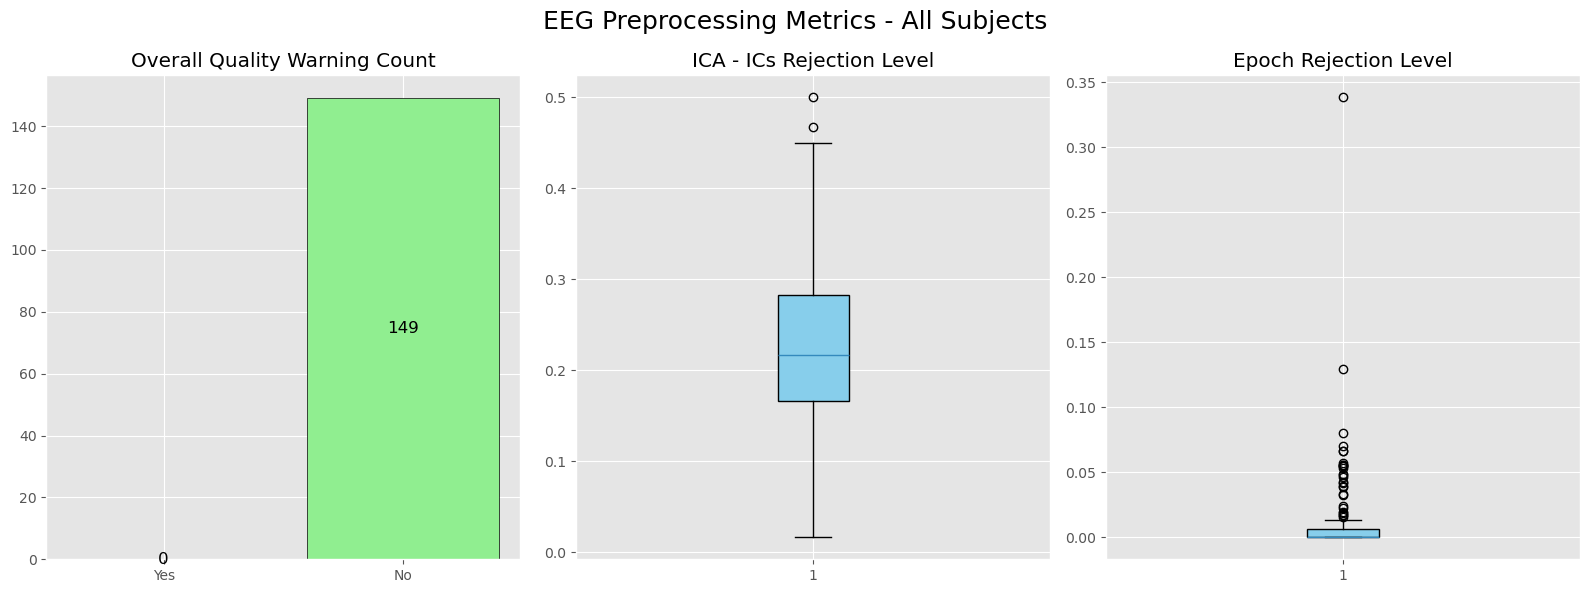

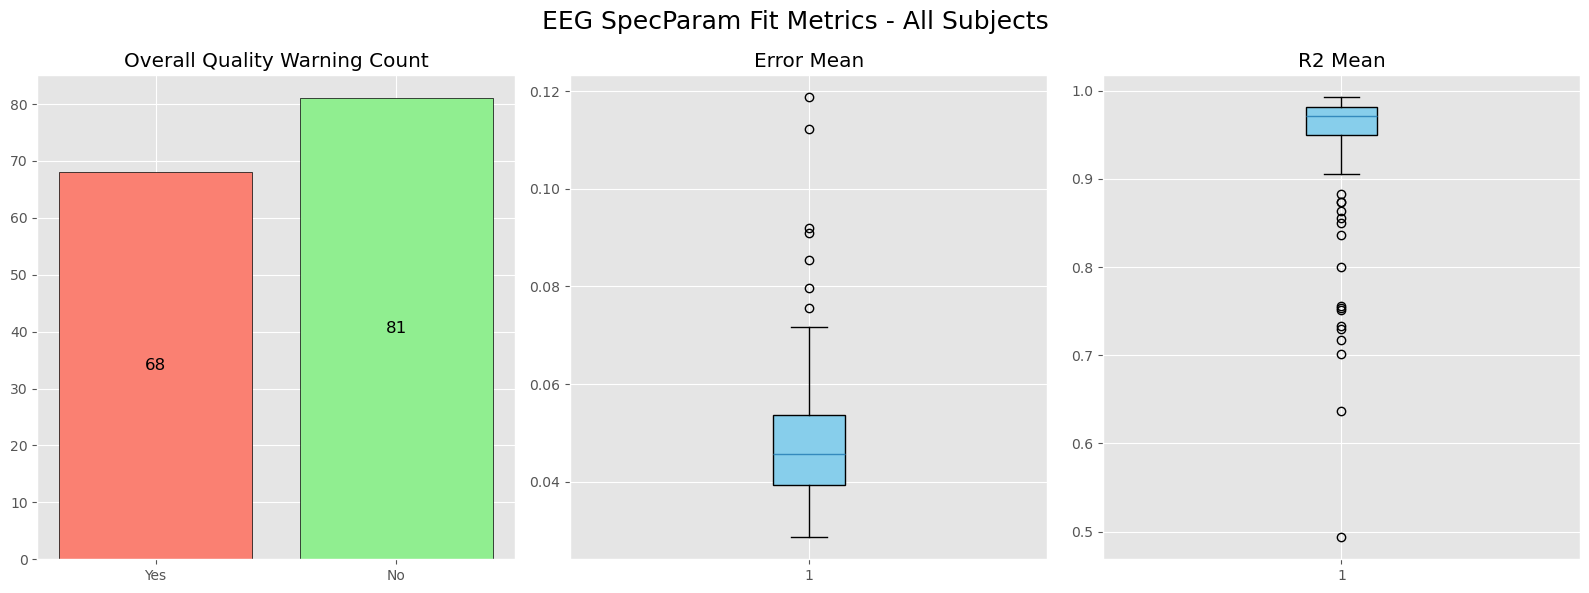

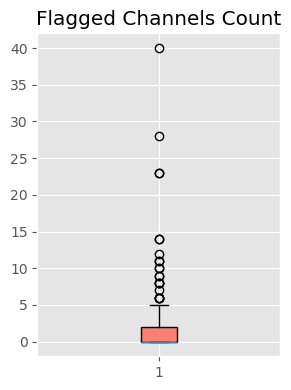

In [18]:
# Processing Run Details & Data Structures
summary = f'EEG Processing Parameters'
summary = summary + f"\n- Study: {study_info['study_name']} {study_info['dataset_ref']}"
summary = summary + f"\n- EEG Processing Run: {eeg_preprocessing_run_details['run_name']}"
summary = summary + f"\n-   Preprocess Params: {eeg_preprocessing_run_details['preprocess_params']}"
summary = summary + f"\n-   ICA Params: {eeg_preprocessing_run_details['artefact_params']}"
summary = summary + f"\n- EEG Features Run: {eeg_features_run}"
summary = summary + f"\n-   PSD Params: {eeg_features_run_details['psd_params']}"
summary = summary + f"\n-   SpecParam Params: {eeg_features_run_details['specparam_params']}"
summary = summary + f"\n- Features Selection Run: {run_name}"
summary = summary + f"\n-   Feature Selection Params: {run_details['extraction_params']}"
summary = summary + f"\n-   Model Training Params: {run_details['model_training_params']}"

print(f'{summary}\n')

# Processing Metrics
print('EEG Processing Results')
print(eeg_processing_results_df.shape)
display(eeg_processing_results_df.head())

print(f'Null Fits: {sum(eeg_processing_results_df["chn_null_fits"])}')
eeg_preprocess_results_plot(eeg_processing_results_df)
eeg_specparam_results_plot(eeg_processing_results_df)


Study Subjects
(149, 5)


,study_name,subject_id,pd,age,gender
0,IOWA_Rest,sub-001,1,80,M
1,IOWA_Rest,sub-002,1,81,M
2,IOWA_Rest,sub-003,1,68,F
3,IOWA_Rest,sub-004,1,80,M
4,IOWA_Rest,sub-005,1,56,M


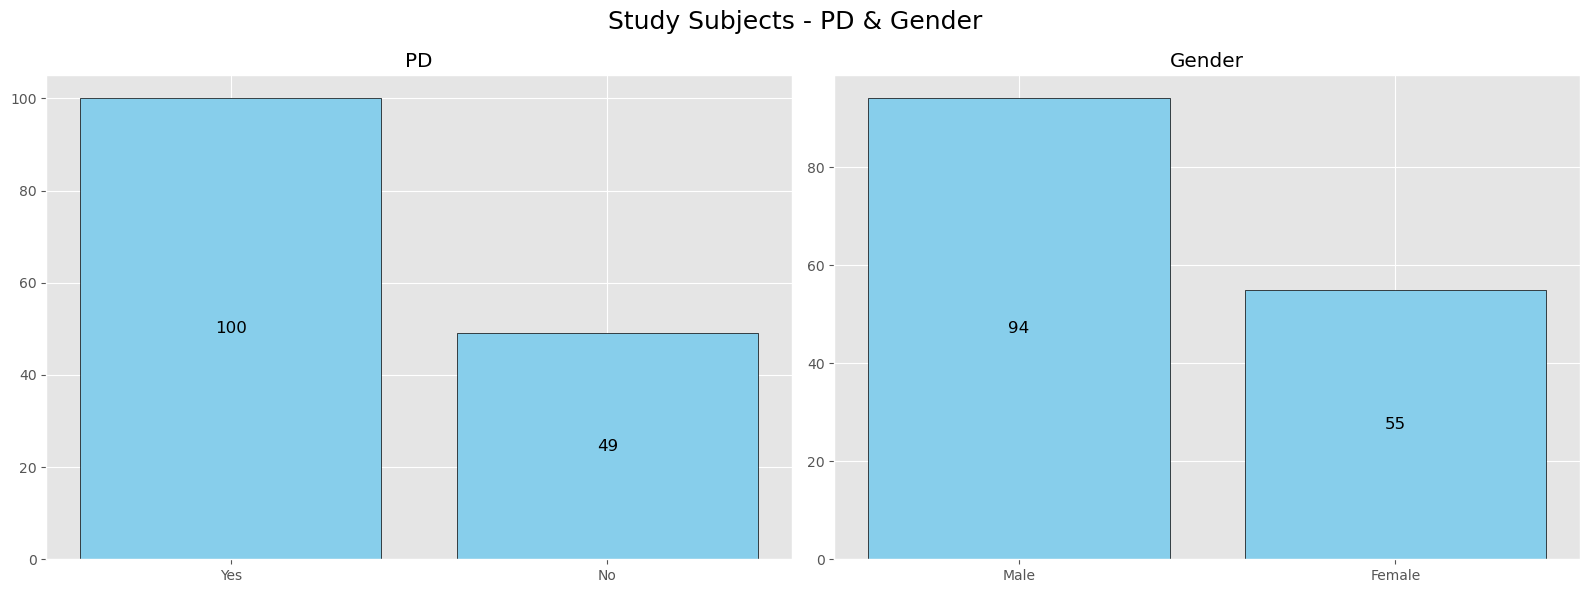

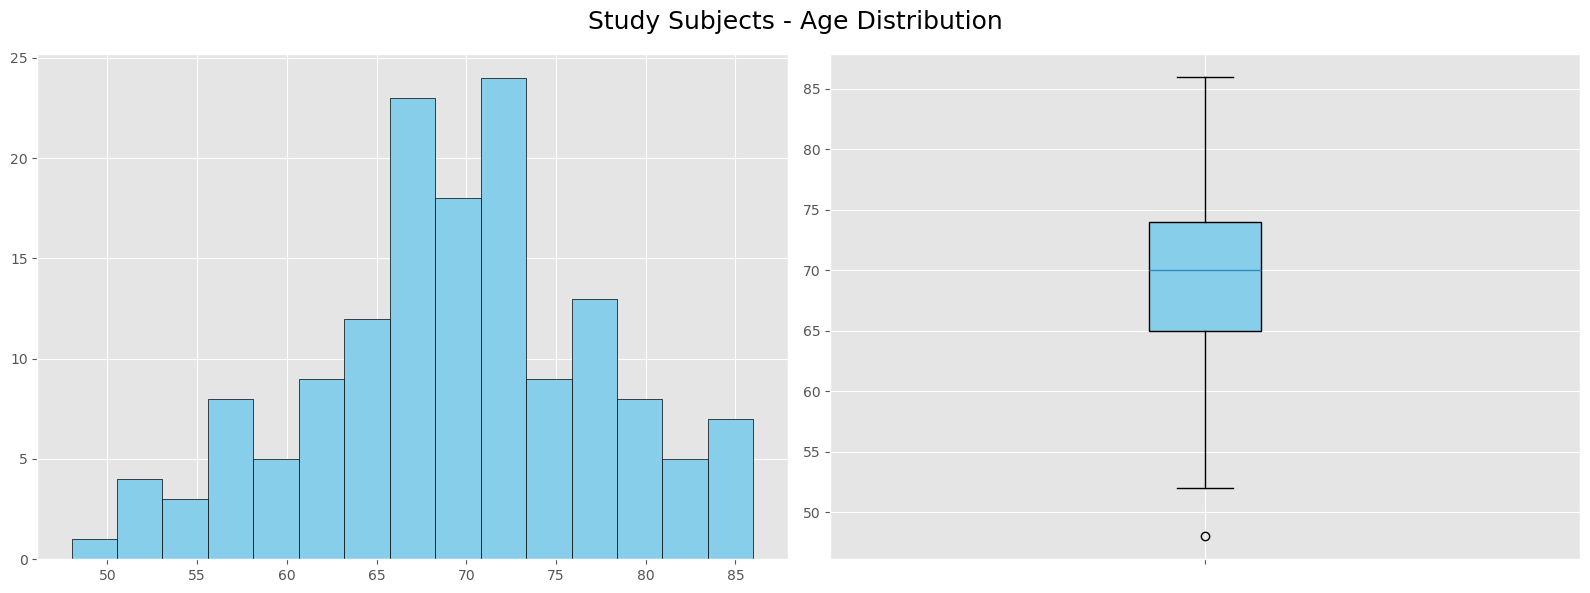

In [19]:
# Study Subjects Summary
print('Study Subjects')
print(study_subjects_df.shape)
display(study_subjects_df.head())

subject_info_plot(study_subjects_df)

In [20]:
# Features Superset 
print('EEG Features Superset')
print(eeg_features_superset_df.shape)
display(eeg_features_superset_df.head())

# Features Flattened 
print('EEG Features Flattened')
print(eeg_features_flattened_df.shape)
display(eeg_features_flattened_df.head())


EEG Features Superset
(9556, 25)


,subject_id,region,channel,offset,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,...,pw_3,bw_3,cf_4,pw_4,bw_4,cf_5,pw_5,bw_5,error,r_squared
0,sub-001,frontal,NaN,-12.147619,0.481923,7.124575,0.382933,3.661685,25.565920,0.279289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034690,0.944893
1,sub-001,central,NaN,-13.225069,0.001710,6.783147,0.275626,2.065892,24.000274,0.400991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042600,0.831166
2,sub-001,posterior,NaN,-11.600760,1.001592,7.041851,0.623959,3.047822,10.205950,0.359989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035003,0.990475
3,sub-001,NaN,Fp1,-12.200923,0.073338,5.000001,0.424577,6.068113,25.200637,0.384810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076825,0.732550
4,sub-001,NaN,Fz,-11.761049,0.695183,6.972525,0.476730,3.088743,9.953165,0.262546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029025,0.982654


EEG Features Flattened
(149, 1478)


,subject_id,pd,age,gender,region_frontal_offset,region_frontal_exponent,region_frontal_cf_0,region_frontal_pw_0,region_frontal_bw_0,region_frontal_cf_1,...,channel_Iz_pw_3,channel_Iz_bw_3,channel_Iz_cf_4,channel_Iz_pw_4,channel_Iz_bw_4,channel_Iz_cf_5,channel_Iz_pw_5,channel_Iz_bw_5,channel_Iz_error,channel_Iz_r_squared
0,sub-001,1,80,M,-12.147619,0.481923,7.124575,0.382933,3.661685,25.565920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-002,1,81,M,-10.770975,1.462089,6.318833,0.594900,2.065198,16.200240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-003,1,68,F,-11.282055,1.181536,11.545416,0.942409,12.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-004,1,80,M,-11.485494,1.369393,6.137473,0.844282,4.052694,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-005,1,56,M,-12.037372,0.511769,6.566139,0.435743,2.000000,13.261402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


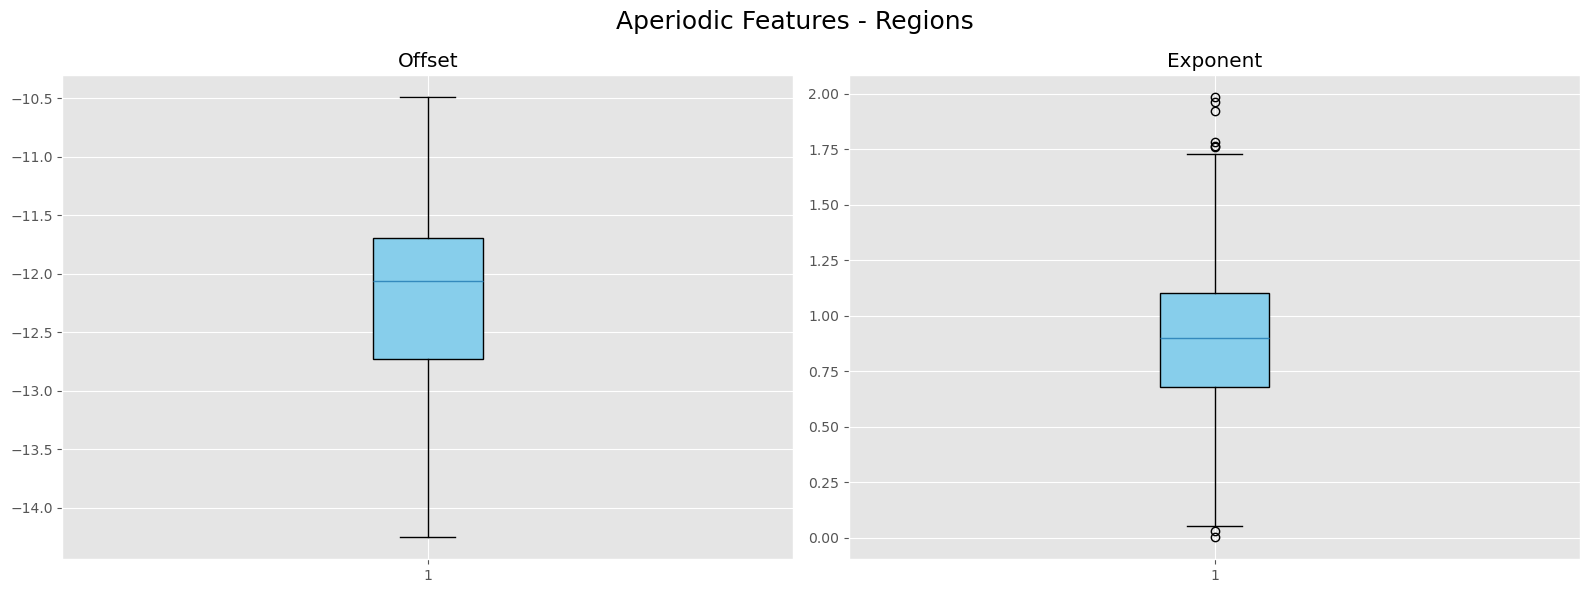

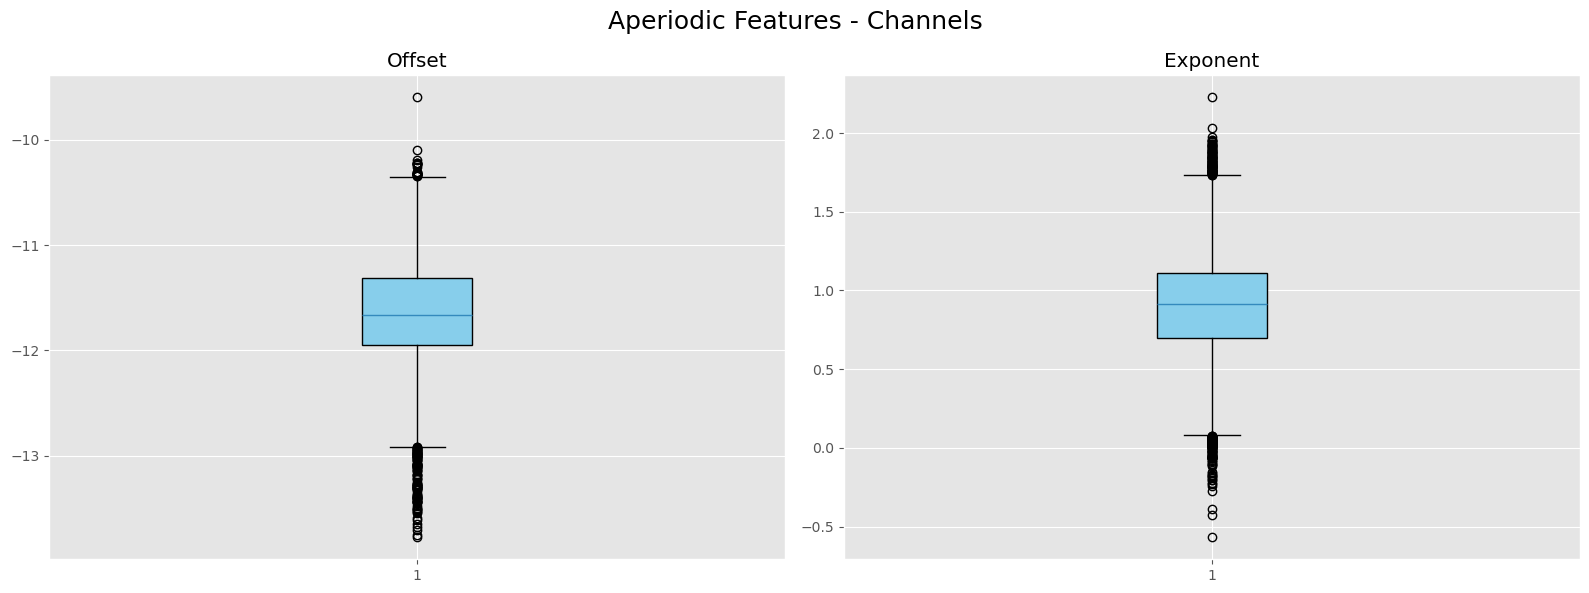

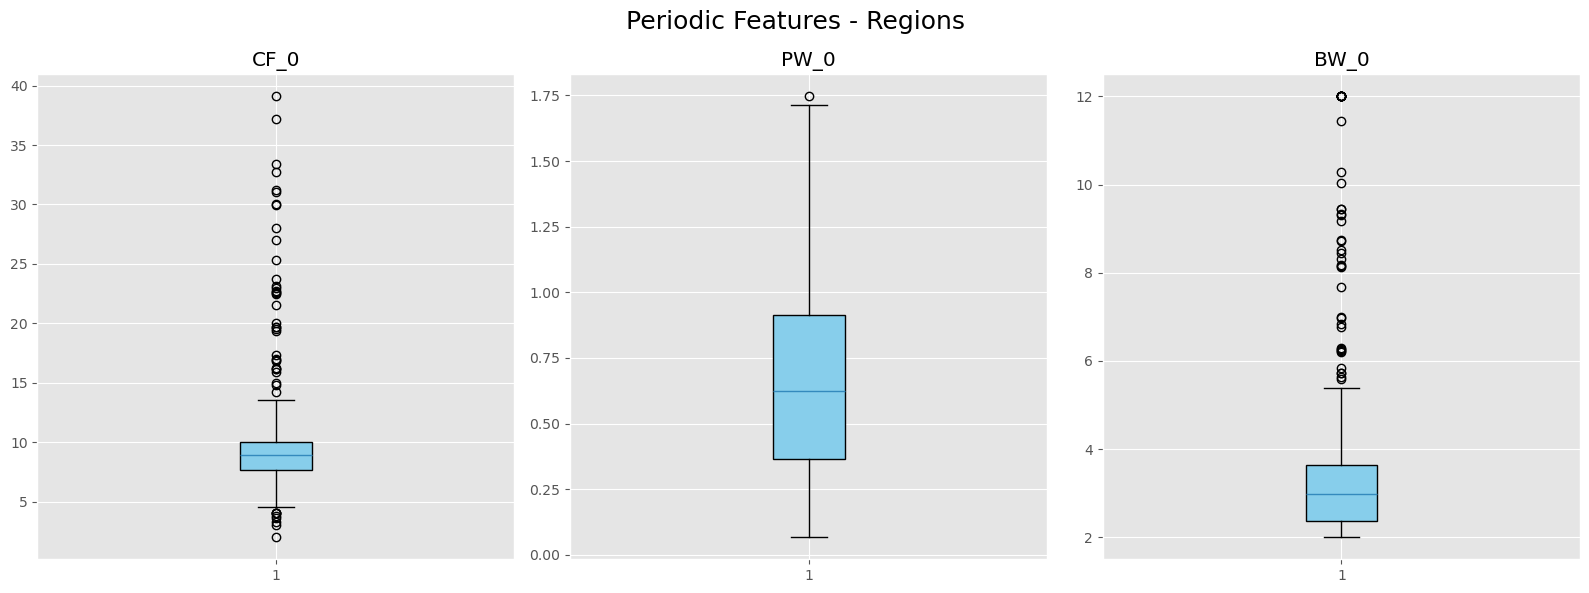

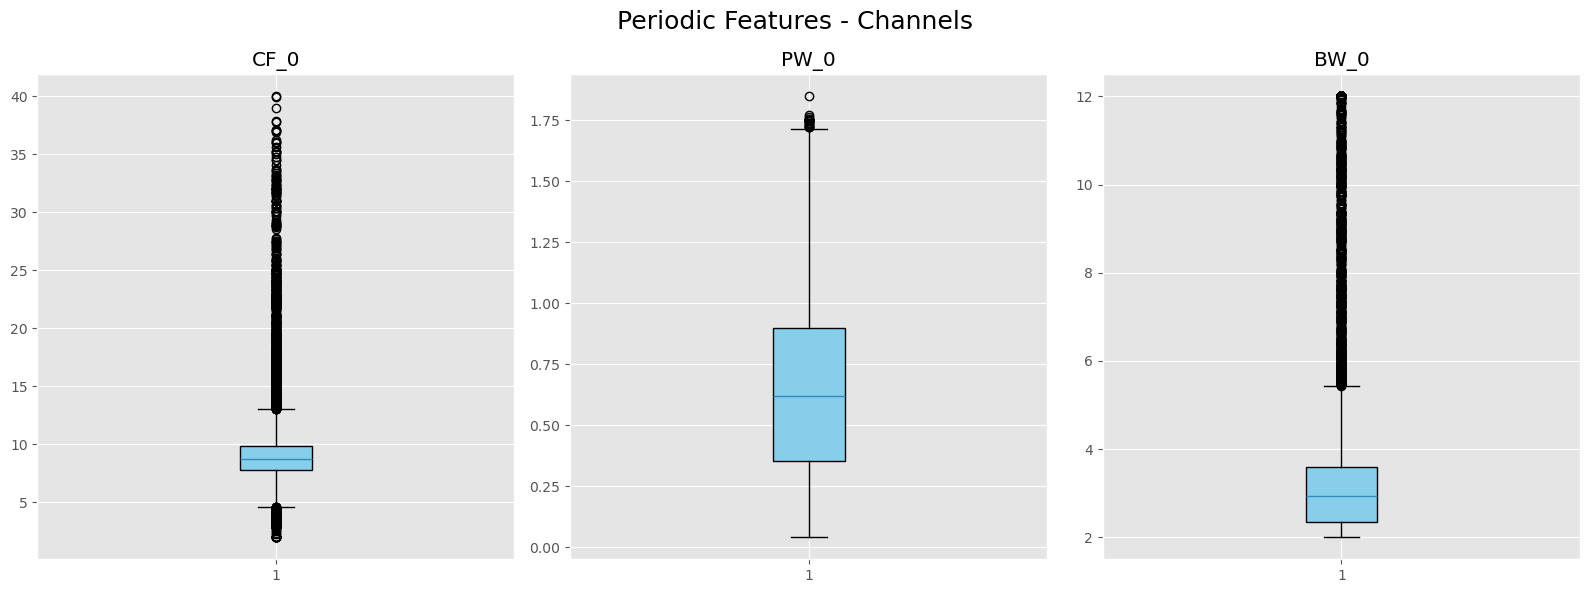

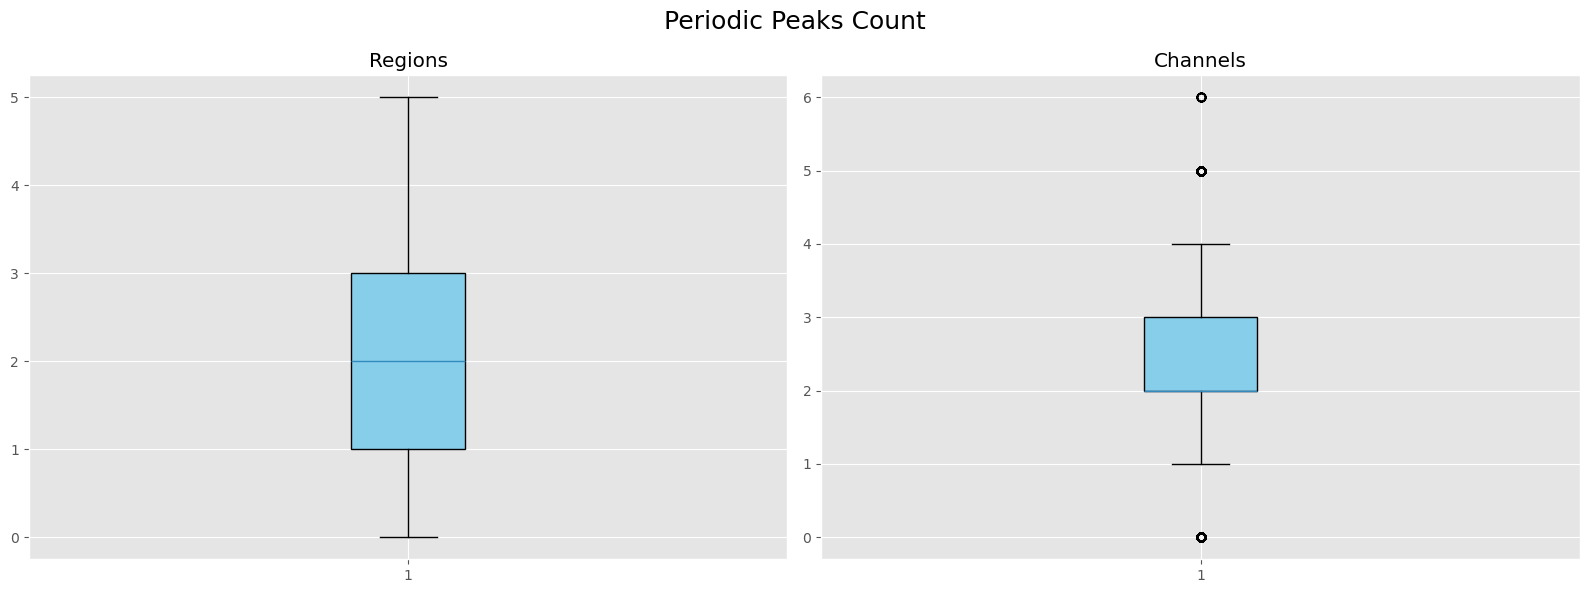

In [21]:
# Features - At Region & Channel Detail Level
#

regions_df = eeg_features_superset_df[eeg_features_superset_df['channel'].isnull()].copy()
channels_df = eeg_features_superset_df[eeg_features_superset_df['region'].isnull()].copy()

aperiodic_features_plot(regions_df, 'Regions')
aperiodic_features_plot(channels_df, 'Channels')

periodic_features_plot(regions_df, 'Regions')
periodic_features_plot(channels_df, 'Channels')

periodic_peaks_plot(eeg_features_superset_df)

# Run: 2. Run Models

In [22]:
# Separate X features and y target
# For Data Pipeline & ML Model Training
#

target_col_name = 'pd'
feature_names = eeg_features_flattened_df.columns[eeg_features_flattened_df.columns != target_col_name]
X = eeg_features_flattened_df[feature_names].copy()
y = eeg_features_flattened_df[target_col_name].copy()

# Data Split : Training & Test, 80:20. NB cross-validation will be performed using Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split by *subjects*, not by raw rows
# train_subj, test_subj = train_test_split(subjects, stratify=labels,
#                                          test_size=.3, random_state=42)
# X_train = eeg_long[eeg_long.subject_id.isin(train_subj)]
# X_test  = eeg_long[eeg_long.subject_id.isin(test_subj)]
# y_train = labels.loc[train_subj].values
# y_test  = labels.loc[test_subj].values


---- Model Training: Random_Forest -------
----Evaluation Result for: RandomForest_v1 -------
Recall (Sensitivity, TP Rate): 0.9474
Precision: 0.7200
F1 Score 0.8182
Specificity (1 - Fall-Out): 0.3636
MCC: 0.4021
-----------
Accuracy: 0.7333
Fall Out (FPR): 0.6364
Hamming Loss 0.2667
ROC-AUC Score 0.7392
Gini Index: 0.4785
-----------


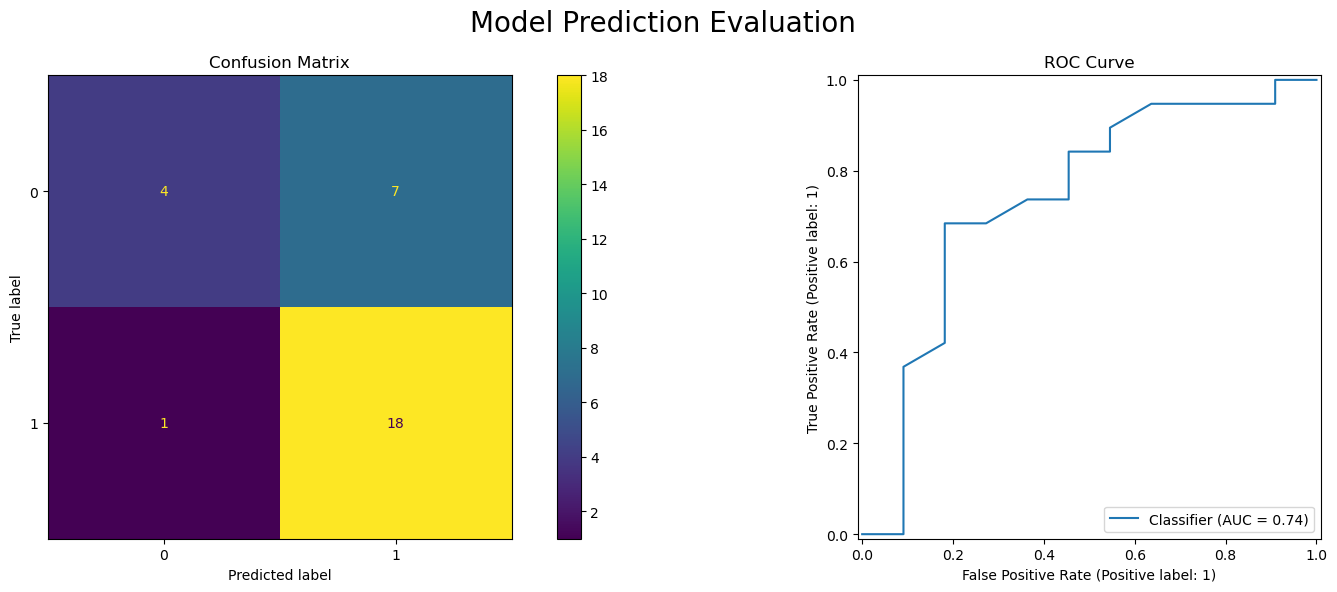

Mismatches


,Ground_Truth,Prediction,Confidence
140,0,1,0.51
109,0,1,0.82
19,1,0,0.58
131,0,1,0.53
127,0,1,0.98
144,0,1,0.67
110,0,1,0.65
101,0,1,0.66


Feature Names: 128


  0%|          | 0/30 [00:00<?, ?it/s]

SHAP Values Importance
(128, 2)


,feature,importance_%
0,numeric__channel_AF8_offset,15.398063
1,numeric__channel_F6_offset,10.384919
2,numeric__channel_CP6_offset,7.433095
3,numeric__channel_FT10_exponent,4.478067
4,numeric__channel_F8_offset,4.227111


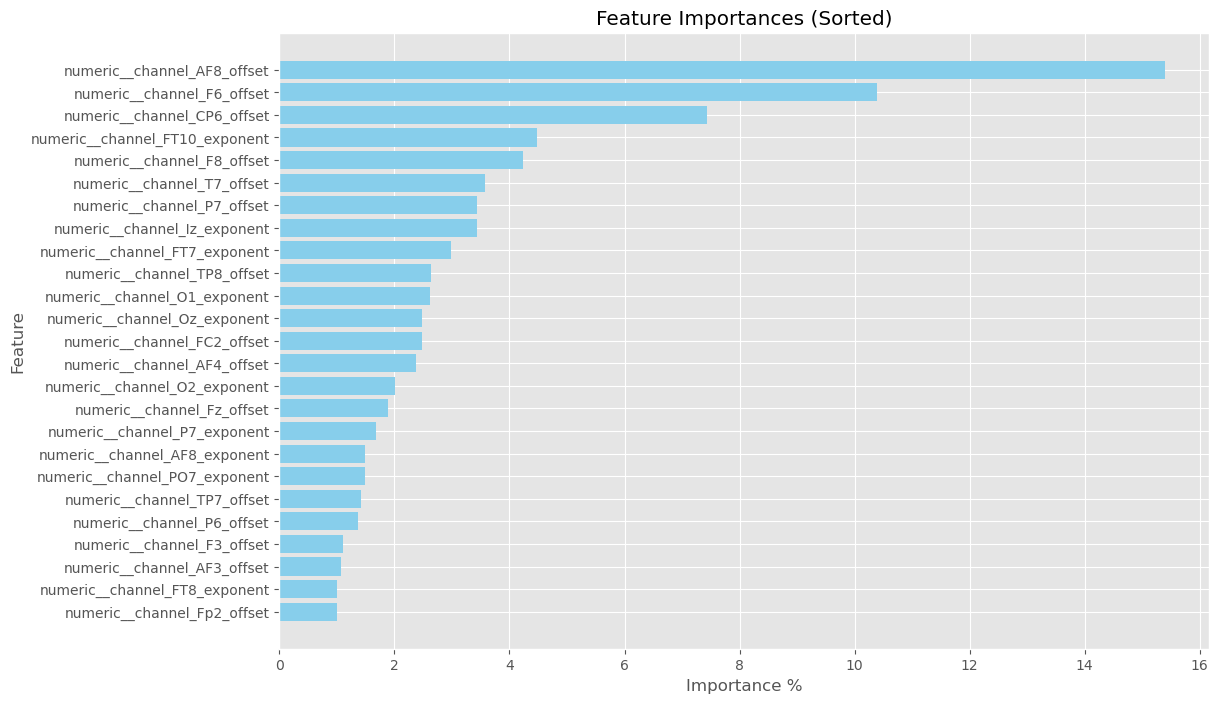

{'study': 'IOWA_Rest', 'training_source_data_run': '1b_EEG_Features_Results_Run_20250801_full_run', 'training_results_run': '2_Feature_Selection_Training_Run_20250810_search_temp', 'CV_search_time': 10.691422792006051, 'CV_best_parameters': {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_leaf_nodes': 50, 'classifier__n_estimators': 100, 'features_selection__features_detail_level': 'channel', 'features_selection__selected_features': ['exp', 'offset']}, 'features_detail': 'channel', 'features_selection': ['exp', 'offset'], 'model_name': 'RandomForest_v1', 'prediction_time': 0.030156416003592312, 'recall': 0.9473684210526315, 'precision': 0.72, 'f1_score': 0.8181818181818182, 'specificity': np.float64(0.36363636363636365), 'mcc': 0.40214734617833486}
---- Model Training Finished & Saved -------


,study,training_source_data_run,training_results_run,CV_search_time,CV_best_parameters,features_detail,features_selection,model_name,prediction_time,recall,precision,f1_score,specificity,mcc
0,IOWA_Rest,1b_EEG_Features_Results_Run_20250801_full_run,2_Feature_Selection_Training_Run_20250810_sear...,10.691423,"{'classifier__criterion': 'entropy', 'classifi...",channel,"[exp, offset]",RandomForest_v1,0.030156,0.947368,0.72,0.818182,0.363636,0.402147


In [ ]:
# Models Training & Evaluations
#

# Feature Selection Params
if extraction_params['features_detail_level'] == 'both':
    detail_level_params = ['region', 'channel']
elif extraction_params['features_detail_level'] == 'region':
    detail_level_params = ['region']
else:
    detail_level_params = ['channel']

# Different Combinations
features_selected = []
features_selected += [['exp', 'offset']] if extraction_params['aperiodic_include'] else []
features_selected += [['cf', 'pw', 'bw']] if extraction_params['periodic_include'] else []
features_selected += [['age', 'gender']] if extraction_params['subject_meta_include'] else []
# ALL Features
# features_selected = [['exp', 'offset', 'cf', 'pw', 'bw']]

# Loop through all models to evaluate
#
models_results = []
function_map = {'Random_Forest': model_train_RandForest,
                'Logistic_Regression': model_train_LogReg
                }
models_list = ['Random_Forest']

for model_name in models_list:
    print(f'---- Model Training: {model_name} -------')
    model_train_func = function_map[model_name]
    model, search_duration, grid_search = model_train_func(X_train, y_train, FeatureSelection(), data_prep_pipeline(), 
                                                            detail_level=detail_level_params,features_selected=features_selected,
                                                            verbose=False)
    
    # Evaluate Model & Features Importance (SHAP)
    eval_results, predictions_df = evaluate_model(model, X_test, y_test)
    contribution_shap(model, X_train, X_test)

    # Append Metrics
    eval_results['study'] = study_name
    eval_results['training_source_data_run'] = eeg_features_run
    eval_results['training_results_run'] = run_name
    eval_results['CV_search_time'] = search_duration
    best_params = grid_search.best_params_
    eval_results['CV_best_parameters'] = best_params
    eval_results['features_detail'] = best_params.get('features_selection__features_detail_level')
    eval_results['features_selection'] = best_params.get('features_selection__selected_features')
    models_results.append(eval_results)
    print(eval_results)

    # Save Model & Grid Search
    cloudpickle.dump(grid_search, open(run_results_path + '/' + f'grid_search_{model_name}.pkl', 'wb'))
    cloudpickle.dump(model, open(run_results_path + '/' + f'model_{model_name}.pkl', 'wb'))
    
# Save All Models Evaluation df
print(f'---- Model Training Finished & Saved -------')
models_results_df = pd.DataFrame(models_results)
display(models_results_df)
models_results_df.to_pickle(run_results_path + '/models_results_df.pkl', compression='zip') 
